In [1]:
# Add your imports here
import pandas as pd
import numpy as np
import scipy as sp
import findspark
import os
findspark.init(os.environ['SPARK_HOME'])
from pyspark.sql import *
from pyspark.sql.functions import *
import matplotlib.pyplot as plt

%matplotlib inline

spark = SparkSession.builder.getOrCreate()


In [2]:
food_facts = spark.read.csv('../data/raw/en.openfoodfacts.org.products.csv', header=True, sep="\t")
food_facts.registerTempTable('food_facts')

In [3]:
food_facts.printSchema()

root
 |-- code: string (nullable = true)
 |-- url: string (nullable = true)
 |-- creator: string (nullable = true)
 |-- created_t: string (nullable = true)
 |-- created_datetime: string (nullable = true)
 |-- last_modified_t: string (nullable = true)
 |-- last_modified_datetime: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- generic_name: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- packaging: string (nullable = true)
 |-- packaging_tags: string (nullable = true)
 |-- brands: string (nullable = true)
 |-- brands_tags: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- categories_tags: string (nullable = true)
 |-- categories_en: string (nullable = true)
 |-- origins: string (nullable = true)
 |-- origins_tags: string (nullable = true)
 |-- manufacturing_places: string (nullable = true)
 |-- manufacturing_places_tags: string (nullable = true)
 |-- labels: string (nullable = true)
 |-- labels_tags: string (nullable 

In [4]:
number_of_products = food_facts.count()
print(number_of_products)

689473


In [5]:
print("Number of distinct city tags without france: {}".format(
    food_facts.select('cities_tags').filter('cities_tags NOT LIKE "%france%"')
    .distinct().count())
)
print("Number of distinct city tags : {}".format(
    food_facts.select('cities_tags').distinct().count())
)

Number of distinct city tags without france: 3
Number of distinct city tags : 3322


In [6]:
print("Number of distinct purchase places without france in the name: {}".format(
    food_facts.select('purchase_places').filter('LOWER(purchase_places) NOT LIKE "%france%"')
    .distinct().count()))
print("Number of distinct purchase places : {}".format(
    food_facts.select('purchase_places').distinct().count()))

Number of distinct purchase places without france in the name: 3412
Number of distinct purchase places : 7733


In [7]:
print("Number of manufacturing places without france in the name: {}".format(
    food_facts.select('manufacturing_places_tags')
              .filter('LOWER(manufacturing_places_tags) NOT LIKE "%france%"')
              .distinct().count())
)
print("Number of manufacturing places : {}".format(
    food_facts.select('manufacturing_places_tags').distinct().count())
)

Number of manufacturing places without france in the name: 7501
Number of manufacturing places : 11866


It seems more interesting to make an analysis focused on the French situation rather than the situation in the US.

In [9]:
food_facts.select('generic_name').filter('generic_name IS NOT NULL') \
    .distinct().toPandas().head(20)

,generic_name
0,Banana & Berries - Banane et baies
1,Boisson au jus de cranberry
2,Bebida de almendras UHT con calcio y vitaminas
3,Cereal de maiz inflado endulzado
4,Base en pâte brisée avec du bœuf d'origine bri...
5,Purée d'amandes
6,Multi-Grain Cheerios
7,Lait
8,Pain sans gluten
9,Enriched Macaroni Product


We'll probably have to filter out the names that are not present in French.

In [10]:
nutrition_grades = food_facts.select(
    'nutrition_grade_fr', 'nutrition_grade_uk', 'code'
    ).filter('nutrition_grade_fr IS NOT NULL OR nutrition_grade_uk IS NOT NULL').toPandas()
print("Total number of products for which we have nutrition informations: {}"
      .format(nutrition_grades.count())
)
print("Proportion of products for which we have nutrition informations: {ratio:.3%}"
      .format(ratio=(nutrition_grades['code'].count()/number_of_products))
)
print("Description of the table: ")
nutrition_grades.describe()

Total number of products for which we have nutrition informations: nutrition_grade_fr    138913
nutrition_grade_uk         0
code                  138913
dtype: int64
Proportion of products for which we have nutrition informations: 20.148%
Description of the table: 


,nutrition_grade_fr,nutrition_grade_uk,code
count,138913,0.0,138913
unique,5,0.0,138909
top,d,NaN,327016058755
freq,40532,NaN,2


`nutrition_grade_uk` is useless.

In [11]:
nutrition_grades = nutrition_grades[['nutrition_grade_fr', 'code']]
nutrition_grades['nutrition_grade_fr'] = nutrition_grades['nutrition_grade_fr'].astype('category')
nutrition_grades.set_index('code', inplace=True)
nutrition_grades.describe()

,nutrition_grade_fr
count,138913
unique,5
top,d
freq,40532


In [12]:
def grade_to_number(x):
    print(x)
    if x == "a":
        return 1
    if x == "b":
        return 2
    if x == "c":
        return 3
    if x == "d":
        return 4
    if x == "e":
        return 5
    return None
nutrition_grades['nutrition_grade_numeric'] = nutrition_grades['nutrition_grade_fr'].apply(grade_to_number).astype('int')

a
b
c
d
e


In [13]:
nutrition_grades.head()

,nutrition_grade_fr,nutrition_grade_numeric
code,,
0000000001281,d,4
0000000001885,a,1
0000000005470,a,1
0000000005661,d,4
0000000125512,e,5


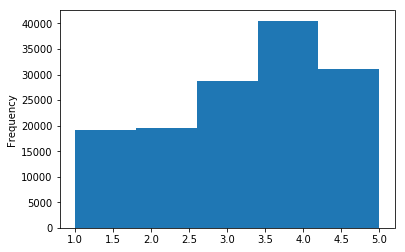

In [14]:
nutrition_grades['nutrition_grade_numeric'].plot.hist(bins=5)

## Data cleaning

In [3]:
# select only the columns we plan to use
food_dataframe = food_facts.select('generic_name',
                                   'code',
                                   'nutrition_grade_fr',
                                   'energy_100g',
                                   'energy-from-fat_100g', 
                                   'trans-fat_100g',
                                   'fat_100g',
                                   'saturated-fat_100g',
                                   'monounsaturated-fat_100g',
                                   'polyunsaturated-fat_100g',
                                   'cholesterol_100g',
                                   'proteins_100g',
                                   'carbohydrates_100g', 
                                   'sugars_100g', 
                                   'fiber_100g',
                                   'fruits-vegetables-nuts_100g',
                                   'fruits-vegetables-nuts-estimate_100g',
                                   'glycemic-index_100g',
                                   'cities',
                                   'cities_tags',
                                   'purchase_places',
                                   'stores',
                                   'countries',
                                   'countries_tags')
# move to pandas for the rest of the analysis
food_dataframe = food_dataframe.toPandas()

We first remove all products that are not sold in France.

In [4]:
food_dataframe = food_dataframe[np.logical_not(food_dataframe['countries_tags'].apply(
                                        lambda x: x is None or "france" not in x.lower())
               & food_dataframe['countries'].apply(lambda x: x is None or "france" not in x.lower())
               & food_dataframe['cities_tags'].apply(lambda x: x is None or "france" not in x.lower())
               & food_dataframe['cities'].apply(lambda x: x is None or "france" not in x.lower())
               & food_dataframe['purchase_places'].apply(lambda x: x is None or "france" not in x.lower())
               & food_dataframe['stores'].apply(lambda x: x is None or "france" not in x.lower()))]

Now, we want to check how many of our features have a significant amount of entries.

In [5]:
total_rows = len(food_dataframe)
for col in list(food_dataframe.columns):
    none_values = np.count_nonzero(food_dataframe[col].apply(lambda x: x is None))
    not_none_percentage = (total_rows - none_values) / total_rows
    print('Rows that are **not** None in {col}: {p:.3%}'.format(col=col, p=not_none_percentage))

Rows that are **not** None in generic_name : 12.571223463334025 %
Rows that are **not** None in code : 100.0 %
Rows that are **not** None in nutrition_grade_fr : 26.27615289453961 %
Rows that are **not** None in energy_100g : 86.36595541027424 %
Rows that are **not** None in energy-from-fat_100g : 0.02438077350261416 %
Rows that are **not** None in trans-fat_100g : 0.30679139990789484 %
Rows that are **not** None in fat_100g : 85.26678887153139 %
Rows that are **not** None in saturated-fat_100g : 86.0205611189872 %
Rows that are **not** None in monounsaturated-fat_100g : 0.43321022547700533 %
Rows that are **not** None in polyunsaturated-fat_100g : 0.43953116675546083 %
Rows that are **not** None in cholesterol_100g : 0.2995674670182314 %
Rows that are **not** None in proteins_100g : 86.29800529153084 %
Rows that are **not** None in carbohydrates_100g : 85.19929024859358 %
Rows that are **not** None in sugars_100g : 86.04674787571223 %
Rows that are **not** None in fiber_100g : 25.6029

**Based on this, we will have to remove some rows:**

We remove the rows for which we have less than 10% of not None values.

- energy-from-fat_100g
- monounsaturated-fat_100g
- polyunsaturated-fat_100g
- cholesterol_100g
- trans-fat_100g
- fruits-vegetables-nuts_100g
- fruits-vegetables-nuts-estimate_100g
- glycemic-index_100g
- cities
- generic_name

Since we have the code of the product, we drop the generic_name attribute too.

We also need to drop all rows for which we have no information whatsoever (nutrition_grade, fat, saturated fat, sugars, proteins, fiber, carbohydrates, energy).

Finally, we need to drop all rows for which we have no information on the city where it is sold.

In [6]:
# drop the columns with too few values
food_dataframe = food_dataframe.drop(columns=['energy-from-fat_100g', 
                             'monounsaturated-fat_100g', 
                             'polyunsaturated-fat_100g',
                             'cholesterol_100g',
                             'trans-fat_100g',
                             'fruits-vegetables-nuts_100g',
                             'fruits-vegetables-nuts-estimate_100g',
                             'glycemic-index_100g',
                             'glycemic-index_100g',
                             'cities',
                             'generic_name'])

# drop the rows with too little nutritional information
food_dataframe = food_dataframe[np.logical_not(food_dataframe['nutrition_grade_fr'].apply(lambda x: x is None) 
                                               & food_dataframe['energy_100g'].apply(lambda x: x is None) 
                                               & food_dataframe['fat_100g'].apply(lambda x: x is None) 
                                               & food_dataframe['saturated-fat_100g'].apply(lambda x: x is None) 
                                               & food_dataframe['carbohydrates_100g'].apply(lambda x: x is None) 
                                               & food_dataframe['sugars_100g'].apply(lambda x: x is None) 
                                               & food_dataframe['fiber_100g'].apply(lambda x: x is None) 
                                               & food_dataframe['proteins_100g'].apply(lambda x: x is None)
                                              )
                               ]

# drop the rows with no purchase place
food_dataframe = food_dataframe[food_dataframe['purchase_places'].apply(lambda x: x is not None)]

In [7]:
food_dataframe.head()

,code,nutrition_grade_fr,energy_100g,fat_100g,saturated-fat_100g,proteins_100g,carbohydrates_100g,sugars_100g,fiber_100g,cities_tags,purchase_places,stores,countries,countries_tags
106,0000000020114,None,0,0,0,0,0,0,None,None,France,None,en:france,en:france
251,0000000274722,b,450,2.2,0.9,6.8,15.3,0.5,0.5,None,France,Comme J'aime,France,en:france
252,0000000274739,b,455,4.2,2.1,4.4,12.5,1.4,1.8,None,France,None,France,en:france
289,0000007020254,e,213,0,0,0,14,0,0,None,"France,États-Unis",None,"France,États-Unis","en:france,en:united-states"
298,0000009125124,b,1577,0.5,0.1,1.5,93,66,None,None,France,None,France,en:france


In [8]:
total_rows = len(food_dataframe)
for col in list(food_dataframe.columns):
    none_values = np.count_nonzero(food_dataframe[col].apply(lambda x: x is None))
    not_none_percentage = (total_rows - none_values) / total_rows
    print('Rows that are **not** None in {col}: {p:.3%}'.format(col=col, p=not_none_percentage))

Rows that are **not** None in code : 100.0 %
Rows that are **not** None in nutrition_grade_fr : 89.74884974943586 %
Rows that are **not** None in energy_100g : 99.52085103888872 %
Rows that are **not** None in fat_100g : 99.09152184743428 %
Rows that are **not** None in saturated-fat_100g : 97.99841748966972 %
Rows that are **not** None in proteins_100g : 99.25270345514755 %
Rows that are **not** None in carbohydrates_100g : 98.72373472437945 %
Rows that are **not** None in sugars_100g : 98.07900829352636 %
Rows that are **not** None in fiber_100g : 54.709433519913254 %
Rows that are **not** None in cities_tags : 30.579081557893502 %
Rows that are **not** None in purchase_places : 100.0 %
Rows that are **not** None in stores : 75.72898045306685 %
Rows that are **not** None in countries : 99.99706942531431 %
Rows that are **not** None in countries_tags : 99.99706942531431 %


We still have rows for which the city tag is none and the purchase place is very vague, like France or the US. We need to take care of those. We will do it by creating a matching between the Open Food Facts dataset and a dataset including all cities of France.

In [9]:
# The dataframe: 
# https://www.insee.fr/fr/statistiques/3126432

revenue_df = pd.read_excel("../data/raw/base-cc-filosofi-2014.xls", skiprows=[0,1,2,3])

# Drop rows that are not data and reset index
revenue_df.drop(0, inplace=True)
revenue_df.reset_index(inplace=True, drop=True)


# Drop useless columns
revenue_df = revenue_df.drop(columns=['Nombre de ménages fiscaux','Code géographique',
                                      'dont part des salaires, traitements ou chômage (%)',
                                      "dont part des revenus d'activités non salariées (%)",
                                      'dont part des prestations familiales (%)',
                                      'dont part des minima sociaux (%)',
                                      'dont part des prestations logement (%)',
                                      '1er décile du niveau de vie (€)',
                                      '9e décile du niveau de vie (€)',
                                      'Rapport inter-décile 9e décile/1er decile',
                                      'Part des ménages fiscaux imposés (%)'
                                     ]
                            )

# Translate the remaining columns to English
revenue_df = revenue_df.rename(columns={"ANNEE" : "Year",
                                        'Nombre de personnes dans les ménages fiscaux': "Household inhabitants", 
                                        'Médiane du niveau vie (€)': "Median revenue euros", 
                                        'Taux de pauvreté-Ensemble (%)' : "Total poverty rate (%)", 
                                        'Taux de pauvreté-moins de 30 ans (%)' : "Poverty rate (-30) (%)",
                                        'Taux de pauvreté-30 à 39 ans  (%)' : "Poverty rate (30-39) (%)",
                                        'Taux de pauvreté-40 à 49 ans (%)': "Poverty rate (40-49) (%)", 
                                        "Taux de pauvreté-50 à 59 ans (%)" :  "Poverty rate (50-59) (%)", 
                                        "Taux de pauvreté-60 à 74 ans (%)" :  "Poverty rate (60-74) (%)", 
                                        "Taux de pauvreté-75 ans ou plus (%)":  "Poverty rate (75+) (%)", 
                                        "Taux de pauvreté-propriétaires (%)" :  "Poverty rate (house owners) (%)", 
                                        "Taux de pauvreté-locataires (%)" :  "Poverty rate (tenants) (%)",
                                        "Part des revenus d'activité (%)" :  "Share of activity revenue (%)", 
                                        'Part des pensions, retraites et rentes (%)' :  "Share of retreat pension revenue (%)", 
                                        'Part des revenus du patrimoine et autres revenus (%)' :  "Share of heritage revenue and other (%)",  
                                        "Part de l'ensemble des prestations sociales (%)" :  "Share of social benefits revenue (%)", 
                                        'Part des impôts (%)' :  "Share of taxes (%)",
                                        'Libellé géographique' : "City name"
                                       }
                              )

In [10]:
revenue_df.head()

,City name,Household inhabitants,Median revenue euros,Total poverty rate (%),Poverty rate (-30) (%),Poverty rate (30-39) (%),Poverty rate (40-49) (%),Poverty rate (50-59) (%),Poverty rate (60-74) (%),Poverty rate (75+) (%),Poverty rate (house owners) (%),Poverty rate (tenants) (%),Share of activity revenue (%),Share of retreat pension revenue (%),Share of heritage revenue and other (%),Share of social benefits revenue (%),Share of taxes (%)
0,L'Abergement-Clémenciat,799.5,21576.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,L'Abergement-de-Varey,235.5,21672.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Ambérieu-en-Bugey,13660.5,19756.1,15.7534,19.4181,19.5204,19.1982,14.7159,NaN,NaN,5.40116,24.796,71.8,27.3,10.1,6.5,-15.7
3,Ambérieux-en-Dombes,1661.5,23204.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ambléon,102,22157.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
print("Total number of rows:", len(revenue_df))

Total number of rows: 36621


In [83]:
print("Total number of cities: ", len(list(set(revenue_df["City name"]))))

Total number of cities:  36621


In [84]:
len(food_dataframe)

68246

In [16]:
# Try to find the intersection between the 2 datasets
# First, let us remove the accents
import unicodedata as ud

def remove_accents(input_str):
    nkfd_form = ud.normalize('NFKD', str(input_str))
    return u"".join([c for c in nkfd_form if not ud.combining(c)])

food_dataframe['purchase_places'] = food_dataframe['purchase_places'].apply(lambda x: remove_accents(x)) 
revenue_df['City name'] = revenue_df['City name'].apply(lambda x: remove_accents(x)) 


In [17]:
revenue_df.head()

,City name,Household inhabitants,Median revenue euros,Total poverty rate (%),Poverty rate (-30) (%),Poverty rate (30-39) (%),Poverty rate (40-49) (%),Poverty rate (50-59) (%),Poverty rate (60-74) (%),Poverty rate (75+) (%),Poverty rate (house owners) (%),Poverty rate (tenants) (%),Share of activity revenue (%),Share of retreat pension revenue (%),Share of heritage revenue and other (%),Share of social benefits revenue (%),Share of taxes (%)
0,L'Abergement-Clemenciat,799.5,21576.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,L'Abergement-de-Varey,235.5,21672.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Amberieu-en-Bugey,13660.5,19756.1,15.7534,19.4181,19.5204,19.1982,14.7159,NaN,NaN,5.40116,24.796,71.8,27.3,10.1,6.5,-15.7
3,Amberieux-en-Dombes,1661.5,23204.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ambleon,102,22157.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
food_dataframe.reset_index(inplace=True)
food_dataframe = food_dataframe[['code', 'nutrition_grade_fr', 'energy_100g',
       'fat_100g', 'saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'cities_tags', 'purchase_places', 'stores',
       'countries', 'countries_tags']]
food_dataframe.head()

,code,nutrition_grade_fr,energy_100g,fat_100g,saturated-fat_100g,proteins_100g,carbohydrates_100g,sugars_100g,fiber_100g,cities_tags,purchase_places,stores,countries,countries_tags
0,0000000020114,None,0,0,0,0,0,0,None,None,France,None,en:france,en:france
1,0000000274722,b,450,2.2,0.9,6.8,15.3,0.5,0.5,None,France,Comme J'aime,France,en:france
2,0000000274739,b,455,4.2,2.1,4.4,12.5,1.4,1.8,None,France,None,France,en:france
3,0000007020254,e,213,0,0,0,14,0,0,None,"France,Etats-Unis",None,"France,États-Unis","en:france,en:united-states"
4,0000009125124,b,1577,0.5,0.1,1.5,93,66,None,None,France,None,France,en:france


In [113]:
# Then, we split into different rows the rows for which 
# purchase_places has several places separated by a comma

food_df = food_dataframe.set_index(
    food_dataframe.columns.drop('cities_tags', 1).values.tolist()
).cities_tags.str.split(',', expand=True).stack(dropna=False).reset_index().rename(
    columns={0:'cities_tags'}
).loc[:, food_dataframe.columns]

In [29]:
food_df.head()

,code,nutrition_grade_fr,energy_100g,fat_100g,saturated-fat_100g,proteins_100g,carbohydrates_100g,sugars_100g,fiber_100g,cities_tags,purchase_places,stores,countries,countries_tags
0,0000000020114,NaN,0,0,0,0,0,0,NaN,None,France,NaN,en:france,en:france
1,0000000020114,NaN,0,0,0,0,0,0,NaN,None,France,NaN,en:france,en:france
2,0000000020114,NaN,0,0,0,0,0,0,NaN,None,France,NaN,en:france,en:france
3,0000000020114,NaN,0,0,0,0,0,0,NaN,None,France,NaN,en:france,en:france
4,0000000020114,NaN,0,0,0,0,0,0,NaN,None,France,NaN,en:france,en:france


In [34]:
list(food_dataframe["cities_tags"].unique())

[None,
 'saint-didier-au-mont-d-or-rhone-france',
 'donzere-drome-france',
 'clecy-calvados-france',
 'saint-alban-les-eaux-loire-france',
 'vergeze-gard-france',
 'chantonnay-vendee-france',
 'sainte-livrade-sur-lot-lot-et-garonne-france',
 'foucarmont-seine-maritime-france',
 'mesnil-en-vallee-maine-et-loire-france',
 'saint-pee-sur-nivelle-pyrenees-atlantiques-france',
 'ducey-manche-france',
 'plelo-cotes-d-armor-france',
 'isigny-sur-mer-calvados-france',
 'saint-martin-des-entrees-calvados-france',
 'annot-alpes-de-haute-provence-france',
 'avoudrey-doubs-france,avoudrey-doubs-france',
 'larceveau-arros-cibits-pyrenees-atlantiques-france',
 'villaz-haute-savoie-france',
 'brignais-rhone-france',
 'requeil-sarthe-france',
 'jonzac-charente-maritime-france',
 'quimperle-finistere-france',
 'broons-cotes-d-armor-france',
 'celles-sur-belle-deux-sevres-france',
 'kervignac-morbihan-france,kervignac-morbihan-france',
 'nantes-loire-atlantique-france',
 'chateau-gontier-mayenne-france'

In [36]:
list(food_dataframe["purchase_places"].unique())

['France',
 'France,Etats-Unis',
 '1€90',
 'Avion',
 'Suisse',
 'Courrieres,France',
 'Lyon,France,Limoges',
 'France,Nantes',
 'Nantes,France',
 'Liverpool,United Kingdom',
 'France,Paris',
 'Royaume-Uni,France,Paris,Londres',
 'Royaume-Uni,Londres',
 'Royaume-Uni,France',
 'Lille,France',
 'France,Paris,Royaume-Uni',
 'France,Royaume-Uni',
 'Royaume-Uni',
 'United Kingdom',
 'Marseille',
 'Northville,Michigan,United States',
 'Paris,France',
 'Canada',
 'Etats-Unis',
 'Paris',
 'Cabries,France',
 'Antibes,France',
 'San Francisco,California,USA,Polynesie francasie,Arue',
 'Madrid,Espana',
 'France,Trignac',
 'Royaume-Uni,Londres,Angleterre',
 'United States',
 'London,England',
 'Belgique',
 'California',
 'France,Paris,Royaume-Uni,Londres',
 'Paris,Courrieres,France',
 'Papeete,French polynesia',
 'Chicago,Illinois,USA',
 'Los Angeles,California,USA,WAL-MART MEXICO',
 'Seattle,Washington,United States',
 'Etats-Unis,France',
 'WAL-MART MEXICO',
 'France,Trignac,Nantes',
 'meylan,fra

In [74]:
cities_for_food = food_dataframe['cities_tags'].str.split(',', expand=True) \
                    .stack().reset_index().drop(columns='level_1').drop_duplicates()

In [75]:
cities_for_food.head()

,level_0,0
0,218,saint-didier-au-mont-d-or-rhone-france
1,232,donzere-drome-france
2,343,clecy-calvados-france
3,575,saint-alban-les-eaux-loire-france
4,829,vergeze-gard-france


In [73]:
city_names = revenue_df["City name"].str.lower().str.replace("'", "-").reset_index()

In [84]:
sdf_city_names = spark.createDataFrame(city_names)
sdf_cities_for_food = spark.createDataFrame(cities_for_food)
sdf_cities_for_food.createTempView('cities_for_food')
sdf_city_names.createTempView('city_names')

AnalysisException: "Temporary view 'cities_for_food' already exists;"

In [85]:
sdf_cities_for_food.show()

+-------+--------------------+
|level_0|                   0|
+-------+--------------------+
|    218|saint-didier-au-m...|
|    232|donzere-drome-france|
|    343|clecy-calvados-fr...|
|    575|saint-alban-les-e...|
|    829| vergeze-gard-france|
|   1107|chantonnay-vendee...|
|   1160|sainte-livrade-su...|
|   1161|foucarmont-seine-...|
|   1168|mesnil-en-vallee-...|
|   1169|saint-pee-sur-niv...|
|   1174| ducey-manche-france|
|   1184|plelo-cotes-d-arm...|
|   1190|isigny-sur-mer-ca...|
|   1195|saint-martin-des-...|
|   1202|annot-alpes-de-ha...|
|   1206|avoudrey-doubs-fr...|
|   1214|larceveau-arros-c...|
|   1218|villaz-haute-savo...|
|   1219|brignais-rhone-fr...|
|   1220|brignais-rhone-fr...|
+-------+--------------------+
only showing top 20 rows



In [107]:
sdf_joined = spark.sql("""
SELECT city_names.index AS city_index, city_names.`City name` AS city_name, 
       aux.food_item_index, aux.city_tag_from_food_item
FROM city_names
JOIN (
    SELECT MAX(LENGTH(city_names.`City name`)) AS length_city_name, 
           cities_for_food.level_0 AS food_item_index, cities_for_food.`0` AS city_tag_from_food_item
    FROM cities_for_food
    JOIN city_names
    ON cities_for_food.`0` LIKE CONCAT(city_names.`City name`, '%')
    GROUP BY cities_for_food.level_0, cities_for_food.`0`
) AS aux
ON aux.city_tag_from_food_item LIKE CONCAT(city_names.`City name`, '%')
WHERE aux.length_city_name == LENGTH(city_names.`City name`)
""")

In [94]:
sdf_joined.count()

52086

In [109]:
sdf_joined.show()

+----------+--------------------+---------------+-----------------------+
|city_index|           city_name|food_item_index|city_tag_from_food_item|
+----------+--------------------+---------------+-----------------------+
|      4315|sainte-genevieve-...|          66054|   sainte-genevieve-...|
|      4315|sainte-genevieve-...|          52422|   sainte-genevieve-...|
|      4315|sainte-genevieve-...|          47515|   sainte-genevieve-...|
|      4315|sainte-genevieve-...|          52425|   sainte-genevieve-...|
|      4315|sainte-genevieve-...|          52427|   sainte-genevieve-...|
|      8649|saint-barthelemy-...|          38955|   saint-barthelemy-...|
|      8649|saint-barthelemy-...|          38952|   saint-barthelemy-...|
|      8649|saint-barthelemy-...|          38953|   saint-barthelemy-...|
|      8649|saint-barthelemy-...|          38951|   saint-barthelemy-...|
|      8649|saint-barthelemy-...|          38957|   saint-barthelemy-...|
|      8649|saint-barthelemy-...|     

In [112]:
sdf_joined.write.mode('overwrite').parquet("sdf_joined_city_names.parquet")

In [111]:
sdf_joined.orderBy('food_item_index').show()

+----------+--------------------+---------------+-----------------------+
|city_index|           city_name|food_item_index|city_tag_from_food_item|
+----------+--------------------+---------------+-----------------------+
|     28581|saint-didier-au-m...|            218|   saint-didier-au-m...|
|      9550|             donzere|            232|   donzere-drome-france|
|      4680|               clecy|            343|   clecy-calvados-fr...|
|     16579|saint-alban-les-eaux|            575|   saint-alban-les-e...|
|     11863|             vergeze|            829|    vergeze-gard-france|
|     34272|          chantonnay|           1107|   chantonnay-vendee...|
|     18116|sainte-livrade-su...|           1160|   sainte-livrade-su...|
|     31068|          foucarmont|           1161|   foucarmont-seine-...|
|     26727|saint-pee-sur-niv...|           1169|   saint-pee-sur-niv...|
|     18885|               ducey|           1174|    ducey-manche-france|
|      7828|               plelo|     